# Tutorial de simulación de lente

Aquí simularemos *CMB lensing* (Efecto lente del CMB), el proceso por el cual las *trayectorias de fotones CMB son desviadas por una estructura a gran escala a medida que atraviesan el Universo.* La temperatura del CMB sin efecto lente $\tilde T(\mathbf n)$ en la posición angular $\mathbf n$ es un campo gaussiano, que hemos visto cómo simular. La acción de la lente es que vemos el CMB evaluado en una *posición desviada* 

$$T^\mathrm{len}(\mathbf n) = \tilde T(\mathbf n + \mathbf d(\mathbf n)). $$

La desviación se da (a buena aproximación) como el *gradiente de un escalar,* 

$$\mathbf d(\mathbf n)= \nabla \phi(\mathbf n),$$

donde $\phi$ es conocido como el **potencial de lente del CMB**. Este campo bidimensional es la proyección de la línea de visión del potencial gravitacional tridimensional de todas las estructuras en el Universo entre nosotros y el CMB. $\phi$ es (aproximadamente) un campo gaussiano, y su espectro de potencia $C_\ell^{\phi\phi}$ se calcula mediante códigos como CAMB. Carguemos los espectros de potencia de temperatura y potencial del CMB, y hagamos una simulación de ambos.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Usamos algunas cosas que aprendimos antes

from cmb_modulos import calcular_espectro_2d, crear_mapa_CMB_T, Graficar_Mapa_CMB
np.random.seed(101)

### Simulando un mapa sin efecto lente



CMB (sin lente)
promedio del mapa: -6.775311596617474 , media cuadrática (rms) del mapa: 101.6967803997967


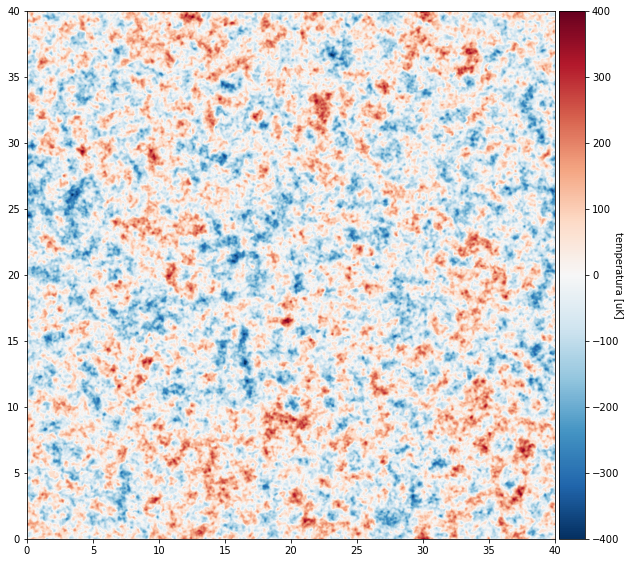

0

In [2]:
largo_parche_grados = 40. #largo del parche en grados
tamaño_pix = 1.5 #tamaño del pixel en arcominutos

# Numero de píxeles en cada dirección
N = int(largo_parche_grados*60./tamaño_pix)

# Necesitamos cargar el espectro teórico
def obtener_teoria():
    ells,tt,_,_,pp,_ = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat",unpack=True)
    TCMB2 = 7.4311e12
    ckk = pp/4./TCMB2
    ucltt = tt / ells/(ells+1.)*2.*np.pi
    ells2,lcltt = np.loadtxt("CMB_fiducial_totalCls.dat",unpack=True,usecols=[0,1])
    lcltt = lcltt / ells2/(ells2+1.)*2.*np.pi
    lcltt = lcltt[:len(ells)]
    return ells,ucltt,lcltt,ckk

ells,ucltt,lcltt,clkk = obtener_teoria()

# Luego generamos un mapa CMB sin lente como un campo aleatorio gaussiano como aprendimos antes
DlTT = ucltt*ells*(ells+1.)/2./np.pi
sinlente = crear_mapa_CMB_T(N,tamaño_pix,ells,DlTT)

## variables para gráficar los mapas
c_min = -400  # mínimo de la barra de color
c_max = 400   # máximo de la barra de color
X_ancho = N*tamaño_pix/60.  # largo horizontal del mapa en grados
Y_ancho = N*tamaño_pix/60.  # largo vertical del mapa en grados

print('CMB (sin lente)')
Graficar_Mapa_CMB(sinlente,c_min,c_max,X_ancho,Y_ancho)


A veces trabajamos con la **convergencia de lente CMB** $\kappa(\mathbf n)$, una proyección de la densidad de la materia. El potencial y la convergencia están relacionados por una ecuación de Poisson, $$\kappa(\mathbf n) = -\nabla^2 \phi(\mathbf n)/2,$$ o en el espacio de Fourier, $$\kappa(\mathbf l) = l^2 \phi(\mathbf l) / 2$$

Hagamos una simulación de $\kappa(\mathbf n)$ -- una proyección de la materia (oscura) entre nosotros y el CMB:


In [3]:
#plt.plot(ells,clkk,"-") #comparar con un valor de una publicacion reciente 

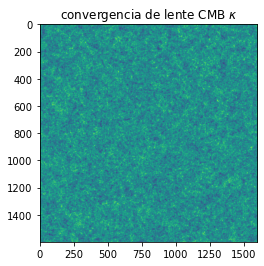

In [4]:
# También necesitamos un mapa de convergencia de lente (kappa)

DlKK = clkk*ells*(ells+1.)/2./np.pi
kappa = crear_mapa_CMB_T(N,tamaño_pix,ells,DlKK)
plt.imshow(kappa)
plt.title('convergencia de lente CMB $\kappa$')
plt.show()

Para simular la acción de **desviación** de la lente, obtendremos nuestro mapa $\phi$ de este mapa $\kappa$; tenemos que evaluar $\nabla \phi$; y determinar las posiciones desplazadas para el CMB, $\mathbf n + \nabla \phi(\mathbf n).$ Haremos la interpolación de la posición real usando `scipy.ndimage.map_coordinates`.

CMB Lenseado
promedio del mapa: -6.851548908295839 , media cuadrática (rms) del mapa: 101.74505266227274


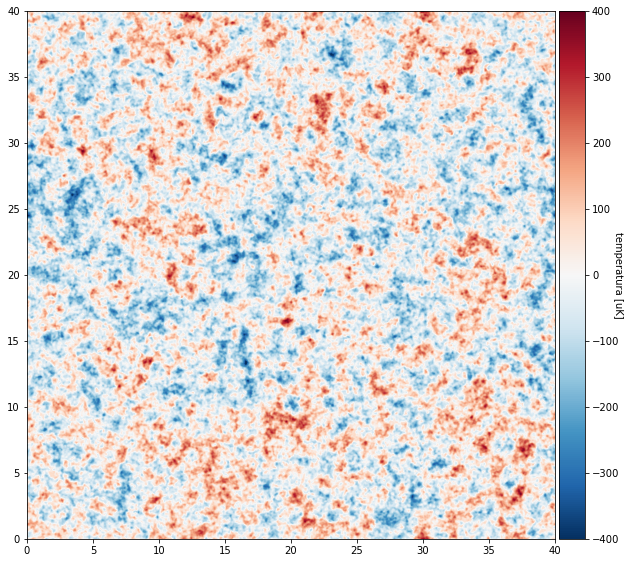

0

In [5]:
def mapa_lenseado(imap,kappa,modlmap,ly,lx,N,pix_size):
    # Primero convertimos la convergencia de lente en potencial de lente.
    phi = kappa_to_phi(kappa,modlmap,return_fphi=True)
    # Luego tomamos su gradiente para obtener el campo de deflexión.
    grad_phi = gradient(phi,ly,lx)
    # Luego calculamos las posiciones desplazadas cambiando las posiciones físicas por las desviaciones
    pos = posmap(N,pix_size) + grad_phi
    # Convertimos las posiciones desplazadas en números de píxeles desplazados fraccionarios
    # porque scipy no sabe de distancias fisicas
    pix = sky2pix(pos, N,pix_size)
    # We prepare an empty output lensed map array
    omap = np.empty(imap.shape, dtype= imap.dtype)
    # Luego le decimos a scipy que calcule los valores del mapa con lente de entrada
    # en las posiciones fraccionarias desplazadas por interpolación y cuadrícula que en el mapa con lente final
    from scipy.ndimage import map_coordinates
    map_coordinates(imap, pix, omap, order=5, mode='wrap')
    return omap

# Esta función necesita conocer las coordenadas de Fourier del mapa.
def get_ells(N,pix_size):
    # Esta función devuelve números de onda de Fourier para una cuadrícula cartesiana cuadrada
    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    ell_scale_factor = 2. * np.pi 
    lx = np.outer(ones,inds) / (pix_size/60. * np.pi/180.) * ell_scale_factor
    ly = np.transpose(lx)
    modlmap = np.sqrt(lx**2. + ly**2.)
    return ly,lx,modlmap

# Necesitamos convertir kappa a phi
def kappa_to_phi(kappa,modlmap,return_fphi=False):
    return filter_map(kappa,kmask(2./modlmap/(modlmap+1.),modlmap,ellmin=2))

# donde usamos una función de enmascaramiento de espacio de Fourier que será útil
def kmask(filter2d,modlmap,ellmin=None,ellmax=None):
    # Aplicar una máscara multipolar mínima y máxima a un filtro
    if ellmin is not None: filter2d[modlmap<ellmin] = 0
    if ellmax is not None: filter2d[modlmap>ellmax] = 0
    return filter2d

# Para hacer eso, también necesitamos saber en general cómo filtrar un mapa.
def filter_map(Map,filter2d):
    FMap = np.fft.fftshift(np.fft.fft2(Map))
    FMap_filtered = FMap * filter2d
    Map_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(FMap_filtered)))
    return Map_filtered


# También necesitamos calcular un gradiente.
# Lo hacemos en el espacio de Fourier
def gradient(imap,ly,lx):
    # Filtra el mapa por (i ly, i lx) para obtener un degradado
    return np.stack([filter_map(imap,ly*1j),filter_map(imap,lx*1j)])

# También necesitábamos el mapa de posiciones físicas
def posmap(N,pix_size):
    pix    = np.mgrid[:N,:N]
    return pix2sky(pix,N,pix_size)

# Para eso, necesitamos poder convertir índices de píxeles en posiciones del cielo.
def pix2sky(pix,N,pix_size):
    py,px = pix
    dec = np.deg2rad((py - N//2 - 0.5)*pix_size/60.)
    ra = np.deg2rad((px - N//2 - 0.5)*pix_size/60.)
    return np.stack([dec,ra])

# Finalmente, para la operación de lente, también necesitábamos convertir las posiciones físicas del 
#cielo en índices de píxeles que es justo lo contrario de lo anterior
def sky2pix(pos,N,pix_size):
    dec,ra = np.rad2deg(pos)*60.
    py = dec/pix_size + N//2 + 0.5
    px = ra/pix_size + N//2 + 0.5
    return np.stack([py,px])

# Nosotros obtenemos las coordenadas de Fourier
ly,lx,modlmap = get_ells(N,tamaño_pix)

# Ahora podemos enfocar nuestro mapa de entrada sin lentes
lenseado = mapa_lenseado(sinlente,kappa,modlmap,ly,lx,N,tamaño_pix)


print('CMB Lenseado')
Graficar_Mapa_CMB(lenseado,c_min,c_max,X_ancho,Y_ancho)


Mapa lenseado menos sin lente
promedio del mapa: -0.07623731167836639 , media cuadrática (rms) del mapa: 20.4594279431126


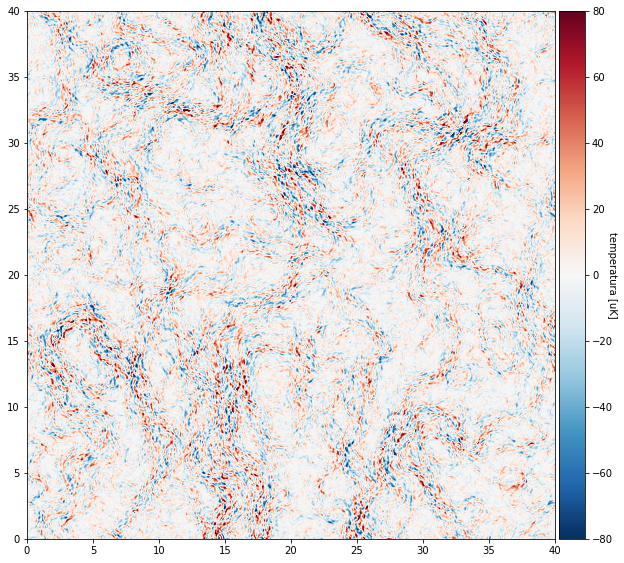

0

In [6]:
print('Mapa lenseado menos sin lente')
Graficar_Mapa_CMB(lenseado - sinlente,c_min/5,c_max/5,X_ancho,Y_ancho) 
#aumentamos el contraste de la imagen en un factor de 5



CMB Observado
promedio del mapa: -6.850893348139814 , media cuadrática (rms) del mapa: 101.4371243057838


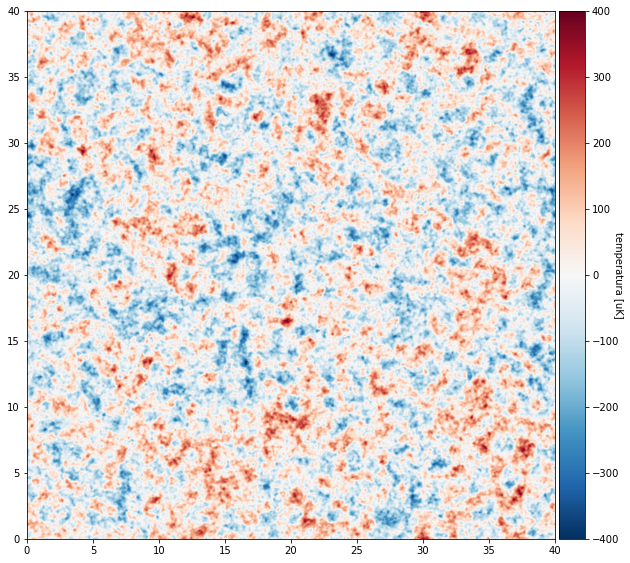

0

In [7]:
#Convolución con el haz y añadir ruido.

# Haz
haz_arcmin = 1.4
def haz_gauss(ell,fwhm):
    # Una función de transferencia de haz gaussiano (mapa-espacio, es decir, una potencia)
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))
# Evaluar el haz en una cuadrícula Fourier isotrópica
kbeam2d = haz_gauss(modlmap,haz_arcmin)
#Filtrar el mapa y convolucionarlo con el haz
conv_haz = filter_map(lenseado,kbeam2d)

# Ruido
ruido_uk_arcmin = 1.5 # nivel de ruido blanco de CMB-S4
# Ruido blanco
Clruido = (ruido_uk_arcmin*np.pi/180./60.)**2.
Dlruido = Clruido*ells*(ells+1.)/2./np.pi
# Crear el mapa de ruido
mapa_ruido = crear_mapa_CMB_T(N,tamaño_pix,ells,Dlruido)

# El mapa observado
observado = conv_haz + mapa_ruido

print('CMB Observado')
Graficar_Mapa_CMB(observado,c_min,c_max,X_ancho,Y_ancho)




<font color='red'>EJERCICIO: </font> Compara el espectro de potencia del mapa de CMB con lente (sin haz, sin ruido) con el mapa CMB sin lente (sin haz, sin ruido). ¿Puedes ver claramente qué características induce la lente? Si es demasiado ruidoso, ¿podrías intentar hacer varias realizaciones y promediarlas a la Monte Carlo?